# Analyse des occupations et leur évolution dans le temps 

Dans ce carnet est proposée...

On met aussi en évidence l'évolution dans le temps ...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys
import pprint

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile



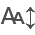

In [5]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)


In [4]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

## Importer les données à analyser

In [6]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/astronomers_import.db')
cn

In [7]:
qr = """
WITH tw1 as (
SELECT DISTINCT wp.personUri, wp.personLabel, 
   -- avec l'instruction CASE on code le genre
   CASE 
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581097'
       THEN 'M'
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581072'
       THEN 'F'
       ELSE 'A'
   END AS gender, wp.birthYear, od.label domaine
FROM wdt_person_occupation po 
    JOIN wdt_occupation wo ON po.occupationUri = wo.wdt_uri
    JOIN wdt_personne wp ON wp.personUri = po.personUri 
    JOIN occupation_domain od ON od.pk_occupation_domain = wo.fk_domain
ORDER BY wp.personUri, od.label )
SELECT personUri, personLabel,gender, birthYear, count(*) as eff, group_concat(domaine)
FROM tw1
GROUP BY personUri, personLabel, birthYear
"""

In [8]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()

In [9]:
print(len(l))
l[:3]

33060


[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'M',
  '1929',
  1,
  'Astronomie'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'M',
  '1892',
  2,
  'Enseignant,Physique'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'M',
  '1924',
  2,
  'Enseignant,Physique')]

In [10]:
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'gender', 'annee_nais', 
                     'eff_occupations', 'liste_occup'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33060 entries, 0 to 33059
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              33060 non-null  object
 1   nom              33060 non-null  object
 2   gender           33060 non-null  object
 3   annee_nais       33060 non-null  object
 4   eff_occupations  33060 non-null  int64 
 5   liste_occup      33060 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [11]:
df_orig.groupby(by='gender').size()

gender
A       13
F     2798
M    30249
dtype: int64

In [130]:
show(df_orig[df_orig.annee_nais < '1901' ].sort_values(by='annee_nais', ascending=True), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)


In [112]:
df_orig[(df_orig.annee_nais > '1780') & (df_orig.annee_nais < '1981') ].groupby(by='eff_occupations')\
    .size()

eff_occupations
1     15176
2      9470
3      3508
4      1006
5       298
6        66
7        23
8         6
9         4
10        2
dtype: int64

In [103]:
df_orig[(df_orig.annee_nais < '1781') ].groupby(by='eff_occupations')\
    .size()

eff_occupations
1     490
2     627
3     554
4     340
5     181
6     104
7      35
8      16
9       5
10      4
11      1
12      1
dtype: int64

In [12]:
# Disciplines principales, disc_princ
a = ['Astrologie', 'Astronomie', 'Physique']

# Activités, activites
b = ['Clerc', 'Ingenieur', 'Chercheur',  'Politique_droit', 'Economie','Enseignant']

# Autres disciplines, disc_autres
c = ['Medecine', 'Philosophie', 'Lettres', 'Arts',  'SHS', 'Pharmacie_chimie', 'Autres_sciences','Mathematiques']


In [133]:
ll = []

## si il n'y a pas d'autres disciplines
# complète avec disciplines principales additionnelles
d = c + a

for e in l[:500]:
    if e[4] > 3:
        e = list(e)
        
        o1 = ''
        for el in a:
            # dès que la variable o1 est remplie sort de la boucle
            if el in e[5] and len(o1) == 0:
                o1 = el
                e.append('d1_'+ el)   
        if not(len(o1) > 0):
            e.append('d1_nr')

        o2 = ''
        for el in b:
            if el in e[5] and len(o2) == 0:
                o2 = el
                e.append('d2_'+ o2)
        if not(len(o2) > 0):
            e.append('d2_nr')


        o3 = ''
        for el in d:
            if el in e[5] and len(o3) == 0\
                  and el != o1:
                o3 = el
                e.append('d3_'+ o3)
        if not(len(o3) > 0):
            e.append('d3_nr')

        o4 = ''
        for el in d:
            if len(o4) == 0 and el in e[5]\
                  and el != o3 and el != o1:
                o4 = el
                e.append('d4_'+ o4)
        if not(len(o4) > 0):
            e.append('d4_nr')

        ll.append(e)

In [ ]:
pprint.pprint(ll[:10])

In [13]:
### Ajout de colonnes supplémentaires sur toute la table
ll = []

## si il n'y a pas d'autres disciplines
# complète avec disciplines principales additionnelles
d = c + a

for e in l:

    e = list(e)
    
    o1 = ''
    for el in a:
        # dès que la variable o1 est remplie sort de la boucle
        if el in e[5] and len(o1) == 0:
            o1 = el
            e.append('d1_'+ el)   
    if not(len(o1) > 0):
        e.append('d1_nr')

    o2 = ''
    for el in b:
        if el in e[5] and len(o2) == 0:
            o2 = el
            e.append('d2_'+ o2)
    if not(len(o2) > 0):
        e.append('d2_nr')


    o3 = ''
    for el in d:
        if el in e[5] and len(o3) == 0\
                and el != o1:
            o3 = el
            e.append('d3_'+ o3)
    if not(len(o3) > 0):
        e.append('d3_nr')

    o4 = ''
    for el in d:
        if len(o4) == 0 and el in e[5]\
                and el != o3 and el != o1:
            o4 = el
            e.append('d4_'+ o4)
    if not(len(o4) > 0):
        e.append('d4_nr')

    ll.append(e)

In [14]:
len(l),len(ll), ll[:3]

(33060,
 33060,
 [['http://www.wikidata.org/entity/Q1000193',
   'Hans Elsässer',
   'M',
   '1929',
   1,
   'Astronomie',
   'd1_Astronomie',
   'd2_nr',
   'd3_nr',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q1000934',
   'Charles Christian Lauritsen',
   'M',
   '1892',
   2,
   'Enseignant,Physique',
   'd1_Physique',
   'd2_Enseignant',
   'd3_nr',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q100153910',
   'Frank J. Blatt',
   'M',
   '1924',
   2,
   'Enseignant,Physique',
   'd1_Physique',
   'd2_Enseignant',
   'd3_nr',
   'd4_nr']])

In [15]:
# deuxième variable considérée comme une activité et non une occupation
df = pd.DataFrame(ll, columns=['uri', 'nom', 'genre', 'annee_nais',
                     'eff_occupations', 'liste_occup', 'o1', 'a1', 'o2', 'o3'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33060 entries, 0 to 33059
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              33060 non-null  object
 1   nom              33060 non-null  object
 2   genre            33060 non-null  object
 3   annee_nais       33060 non-null  object
 4   eff_occupations  33060 non-null  int64 
 5   liste_occup      33060 non-null  object
 6   o1               33060 non-null  object
 7   a1               33060 non-null  object
 8   o2               33060 non-null  object
 9   o3               33060 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.5+ MB


In [16]:
df.groupby(by='o1').size().sort_values(ascending=False)

o1
d1_Physique      23963
d1_Astronomie     8166
d1_Astrologie      931
dtype: int64

In [17]:
df.groupby(by='a1').size().sort_values(ascending=False)

a1
d2_nr                 20562
d2_Enseignant          7136
d2_Chercheur           2015
d2_Ingenieur           1864
d2_Politique_droit      903
d2_Clerc                425
d2_Economie             155
dtype: int64

In [18]:
df[df.o3 != 'd4_nr'].groupby(by='a1').size().sort_values(ascending=False)

a1
d2_nr                 762
d2_Enseignant         513
d2_Chercheur          178
d2_Ingenieur          173
d2_Clerc              142
d2_Politique_droit     85
d2_Economie            16
dtype: int64

In [19]:
df.groupby(by='o2').size().sort_values(ascending=False)

o2
d3_nr                  24950
d3_Mathematiques        2057
d3_Autres_sciences      1619
d3_Lettres              1528
d3_Physique              872
d3_SHS                   626
d3_Medecine              523
d3_Philosophie           480
d3_Arts                  308
d3_Pharmacie_chimie       56
d3_Astronomie             41
dtype: int64

In [20]:
df.groupby(by='o3').size().sort_values(ascending=False)

o3
d4_nr                  31191
d4_Mathematiques         622
d4_Autres_sciences       321
d4_Physique              263
d4_SHS                   253
d4_Lettres               184
d4_Arts                  105
d4_Philosophie            58
d4_Astronomie             50
d4_Pharmacie_chimie       13
dtype: int64

### Codage par période de cinquante ans

In [21]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df['annee_nais'] = df['annee_nais'].astype(int)

In [22]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df[df['annee_nais'] < 1981].copy(deep=True)
cdf_p.head(3)

,uri,nom,genre,annee_nais,eff_occupations,liste_occup,o1,a1,o2,o3
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,1,Astronomie,d1_Astronomie,d2_nr,d3_nr,d4_nr
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,2,"Enseignant,Physique",d1_Physique,d2_Enseignant,d3_nr,d4_nr
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,2,"Enseignant,Physique",d1_Physique,d2_Enseignant,d3_nr,d4_nr


In [23]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1355, 1980)

In [24]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_50 = list(range(1351, 2002, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1801, 1851, 1901, 1951, 2001])

In [25]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,genre,annee_nais,eff_occupations,liste_occup,o1,a1,o2,o3,periodes
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,1,Astronomie,d1_Astronomie,d2_nr,d3_nr,d4_nr,1901-1950
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,2,"Enseignant,Physique",d1_Physique,d2_Enseignant,d3_nr,d4_nr,1851-1900
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,2,"Enseignant,Physique",d1_Physique,d2_Enseignant,d3_nr,d4_nr,1901-1950


In [26]:
cdf_p[cdf_p.annee_nais == 1980][:3]

,uri,nom,genre,annee_nais,eff_occupations,liste_occup,o1,a1,o2,o3,periodes
68,http://www.wikidata.org/entity/Q100711748,Ivelina Momcheva,F,1980,1,Astronomie,d1_Astronomie,d2_nr,d3_nr,d4_nr,1951-2000
398,http://www.wikidata.org/entity/Q102390671,Liza Huijse,F,1980,1,Physique,d1_Physique,d2_nr,d3_nr,d4_nr,1951-2000
404,http://www.wikidata.org/entity/Q102397621,Răzvan Gurău,M,1980,2,"Enseignant,Physique",d1_Physique,d2_Enseignant,d3_nr,d4_nr,1951-2000


In [27]:
### compter les naissances par périodes de 50 ans
cdf_p.groupby(by='periodes', observed=True).size()

periodes
1351-1400       37
1401-1450       66
1451-1500      127
1501-1550      198
1551-1600      286
1601-1650      297
1651-1700      313
1701-1750      618
1751-1800      775
1801-1850     1655
1851-1900     4101
1901-1950    15935
1951-2000     7509
dtype: int64

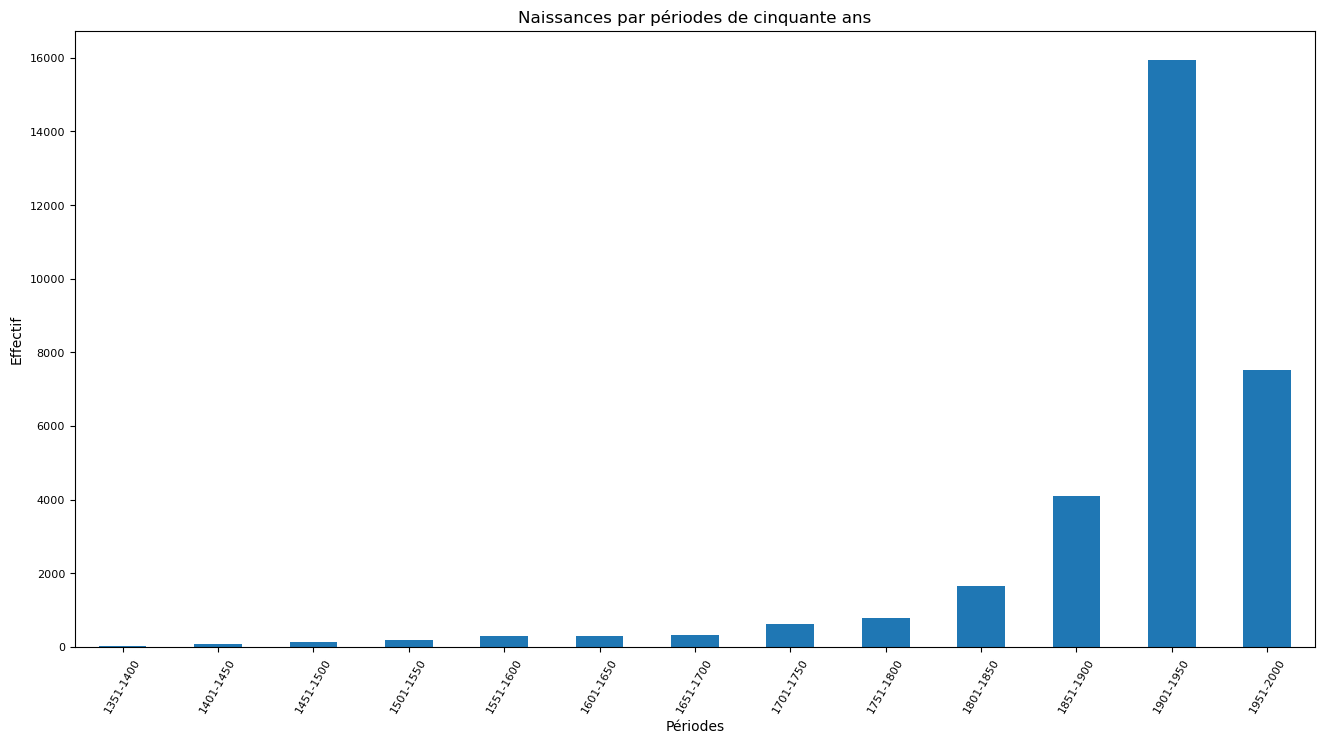

In [28]:
ax = cdf_p.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

## MCA : Représentation graphique

### Tableau à analyser

In [97]:
DActives = cdf_p[cdf_p.annee_nais < 1800][['genre', 'periodes',
 'o1', 'a1', 'o2', 'o3']]

In [130]:
DActives = cdf_p[(cdf_p.annee_nais > 1800)&(cdf_p.genre != 'A')][['genre', 'periodes',
 'o1', 'a1']]

In [155]:
DActives = cdf_p[(cdf_p.annee_nais > 1800)][[ 'periodes',
 'o1', 'a1']]

In [156]:
acm = MCA(row_labels=DActives.index,var_labels=DActives.columns)
acm.fit(DActives.values)

MCA(row_labels=Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,    10,
       ...
       33049, 33050, 33051, 33052, 33053, 33054, 33055, 33057, 33058, 33059],
      dtype='int64', length=29200),
    var_labels=Index(['periodes', 'o1', 'a1'], dtype='object'))

In [157]:
eig = pd.DataFrame(acm.eig_).transpose()
eig.columns=['contribution','freq','freq_cumulee']

eig.head(), eig.tail()


(   contribution       freq  freq_cumulee
 0      0.407686  11.118718     11.118718
 1      0.377395  10.292594     21.411312
 2      0.366648   9.999498     31.410810
 3      0.341269   9.307325     40.718136
 4      0.337780   9.212192     49.930327,
     contribution      freq  freq_cumulee
 6       0.330399  9.010870     68.032107
 7       0.325179  8.868516     76.900623
 8       0.307154  8.376928     85.277552
 9       0.287989  7.854240     93.131791
 10      0.251834  6.868209    100.000000)

In [158]:
### Frequency
eig.iloc[:,1][:5]

0    11.118718
1    10.292594
2     9.999498
3     9.307325
4     9.212192
Name: freq, dtype: float64

In [159]:
#Rcupération des infos - nombre de variables
p = DActives.shape[1]
#nombre d'observations
n = DActives.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
#codage en 0/1
X = pd.get_dummies(DActives,prefix='',prefix_sep='')*1
X.head(3)

Nombre variables: 3 Nombre lignes: 29200


,1351-1400,1401-1450,1451-1500,1501-1550,1551-1600,1601-1650,1651-1700,1701-1750,1751-1800,1801-1850,...,d1_Astrologie,d1_Astronomie,d1_Physique,d2_Chercheur,d2_Clerc,d2_Economie,d2_Enseignant,d2_Ingenieur,d2_Politique_droit,d2_nr
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [165]:
### Nombre total de modalités, toute variable confondue
M = X.shape[1]
print('Nombre de modalités:', M)
#nombre max de facteurs
Hmax = M-p
print('Nombre maximal de facteurs:', Hmax)

Nombre de modalités: 23
Nombre maximal de facteurs: 20


In [163]:
len(acm.eig_[0])

11

In [166]:
Hmax

20

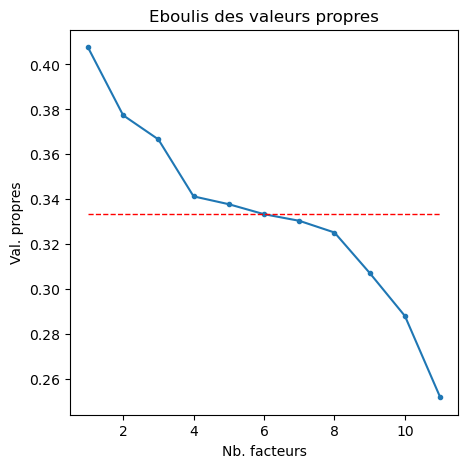

In [174]:
#éboulis des v.p.

xvalues = len(acm.eig_[0])+1

fix,ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,xvalues),acm.eig_[0],".-")
ax.set_xlabel("Nb. facteurs")
ax.set_ylabel("Val. propres")
plt.title("Eboulis des valeurs propres")
#seuil - Règle de Kaiser
ax.plot([1,xvalues-1],[1/p,1/p],"r--",linewidth=1)
plt.show()

*Diagramme d'éboulis*. Représentation graphique ayant pour but d'identifier un point d'inflexion dans une courbe de la variance. Le nom donné à ce type de graphique vient de la ressemblance de la courbe avec le profil des éboulis (scree) au bas d'une falaise. [DataFranca, Diagramme d'éboulis, 2024](https://datafranca.org/wiki/index.php?title=Diagramme_d%27%C3%A9boulis&oldid=93502)

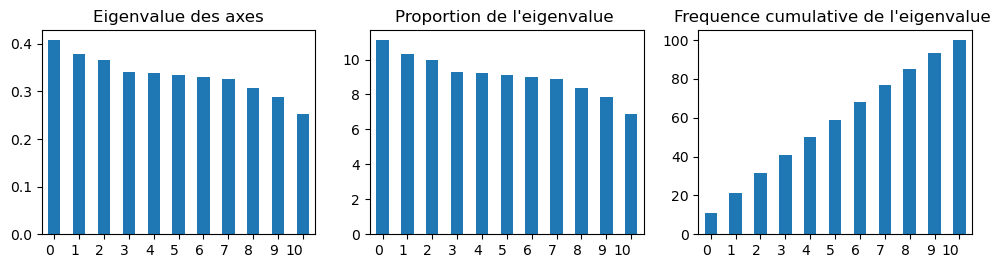

In [175]:
# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

eig.iloc[:,0].plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
eig.iloc[:,1].plot(kind='bar', ax=axes[1], title="Proportion de l'eigenvalue ")
eig.iloc[:,2].plot(kind='bar', ax=axes[2], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

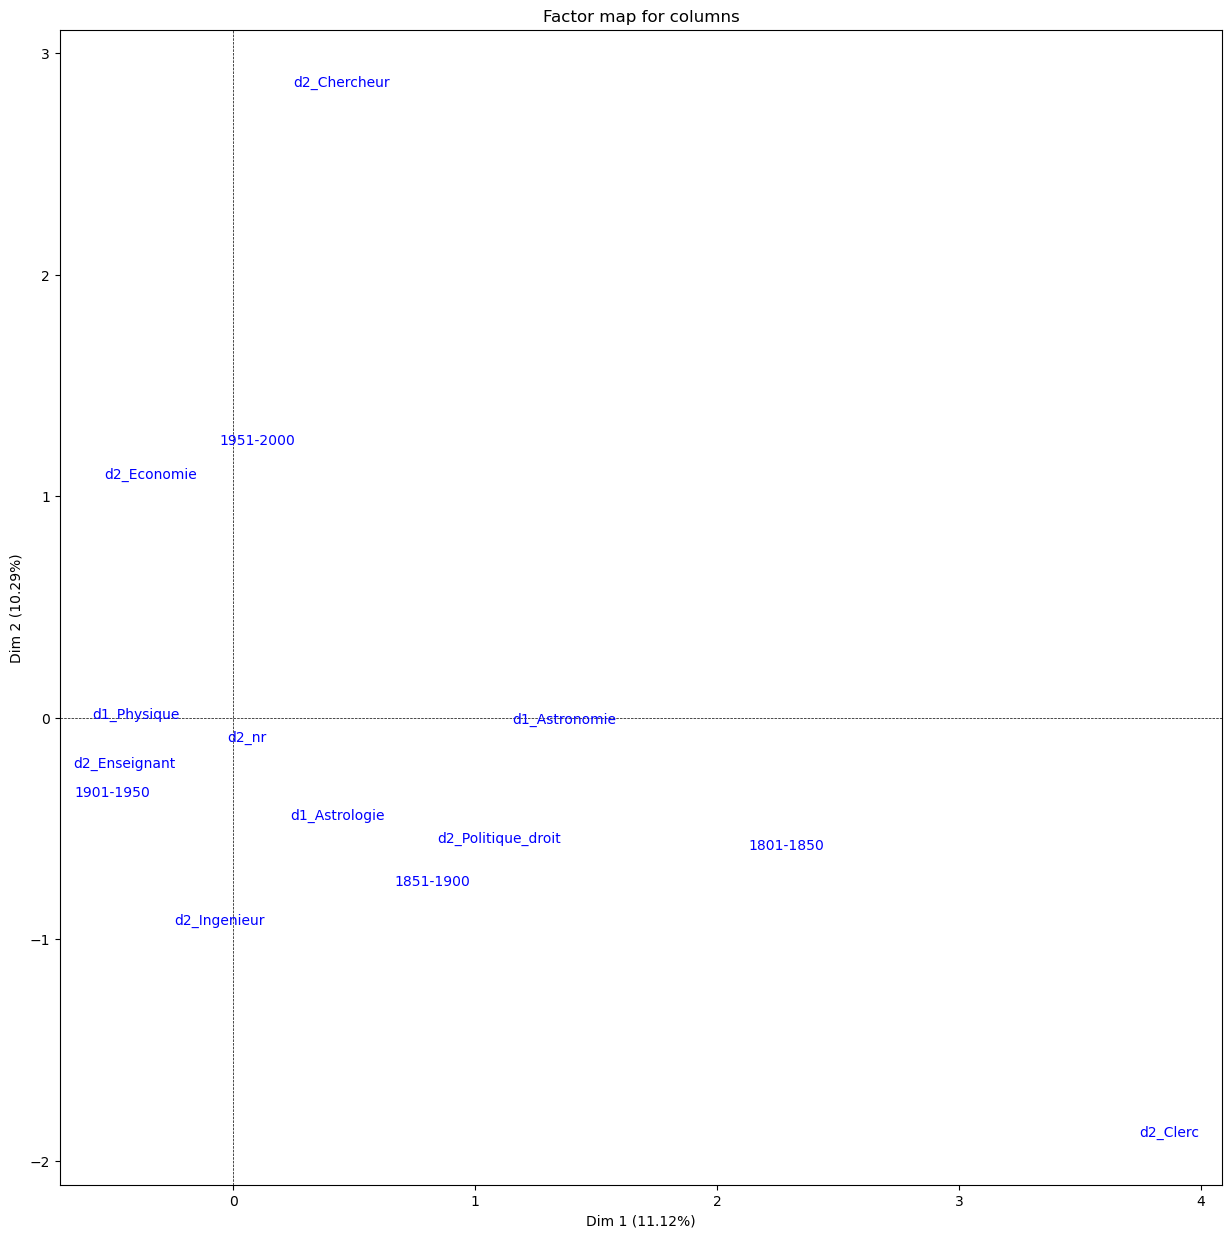

In [176]:
# Mapping des points colonnes
acm.mapping_col(num_x_axis=1, num_y_axis=2, figsize=(15,15))

In [ ]:
# Mapping des points colonnes
acm.mapping_col(num_x_axis=2, num_y_axis=3, figsize=(15,15))

In [ ]:
# Mapping des points colonnes
acm.mapping_col(num_x_axis=3, num_y_axis=4, figsize=(15,15))

In [142]:
# D3fr = acm.row_topandas()[['row_coord_dim1','row_coord_dim2','row_coord_dim3']]
#print(D3fr)
D3fc = acm.col_topandas()[['col_coord_dim1','col_coord_dim2','col_coord_dim3']]
#D3fc

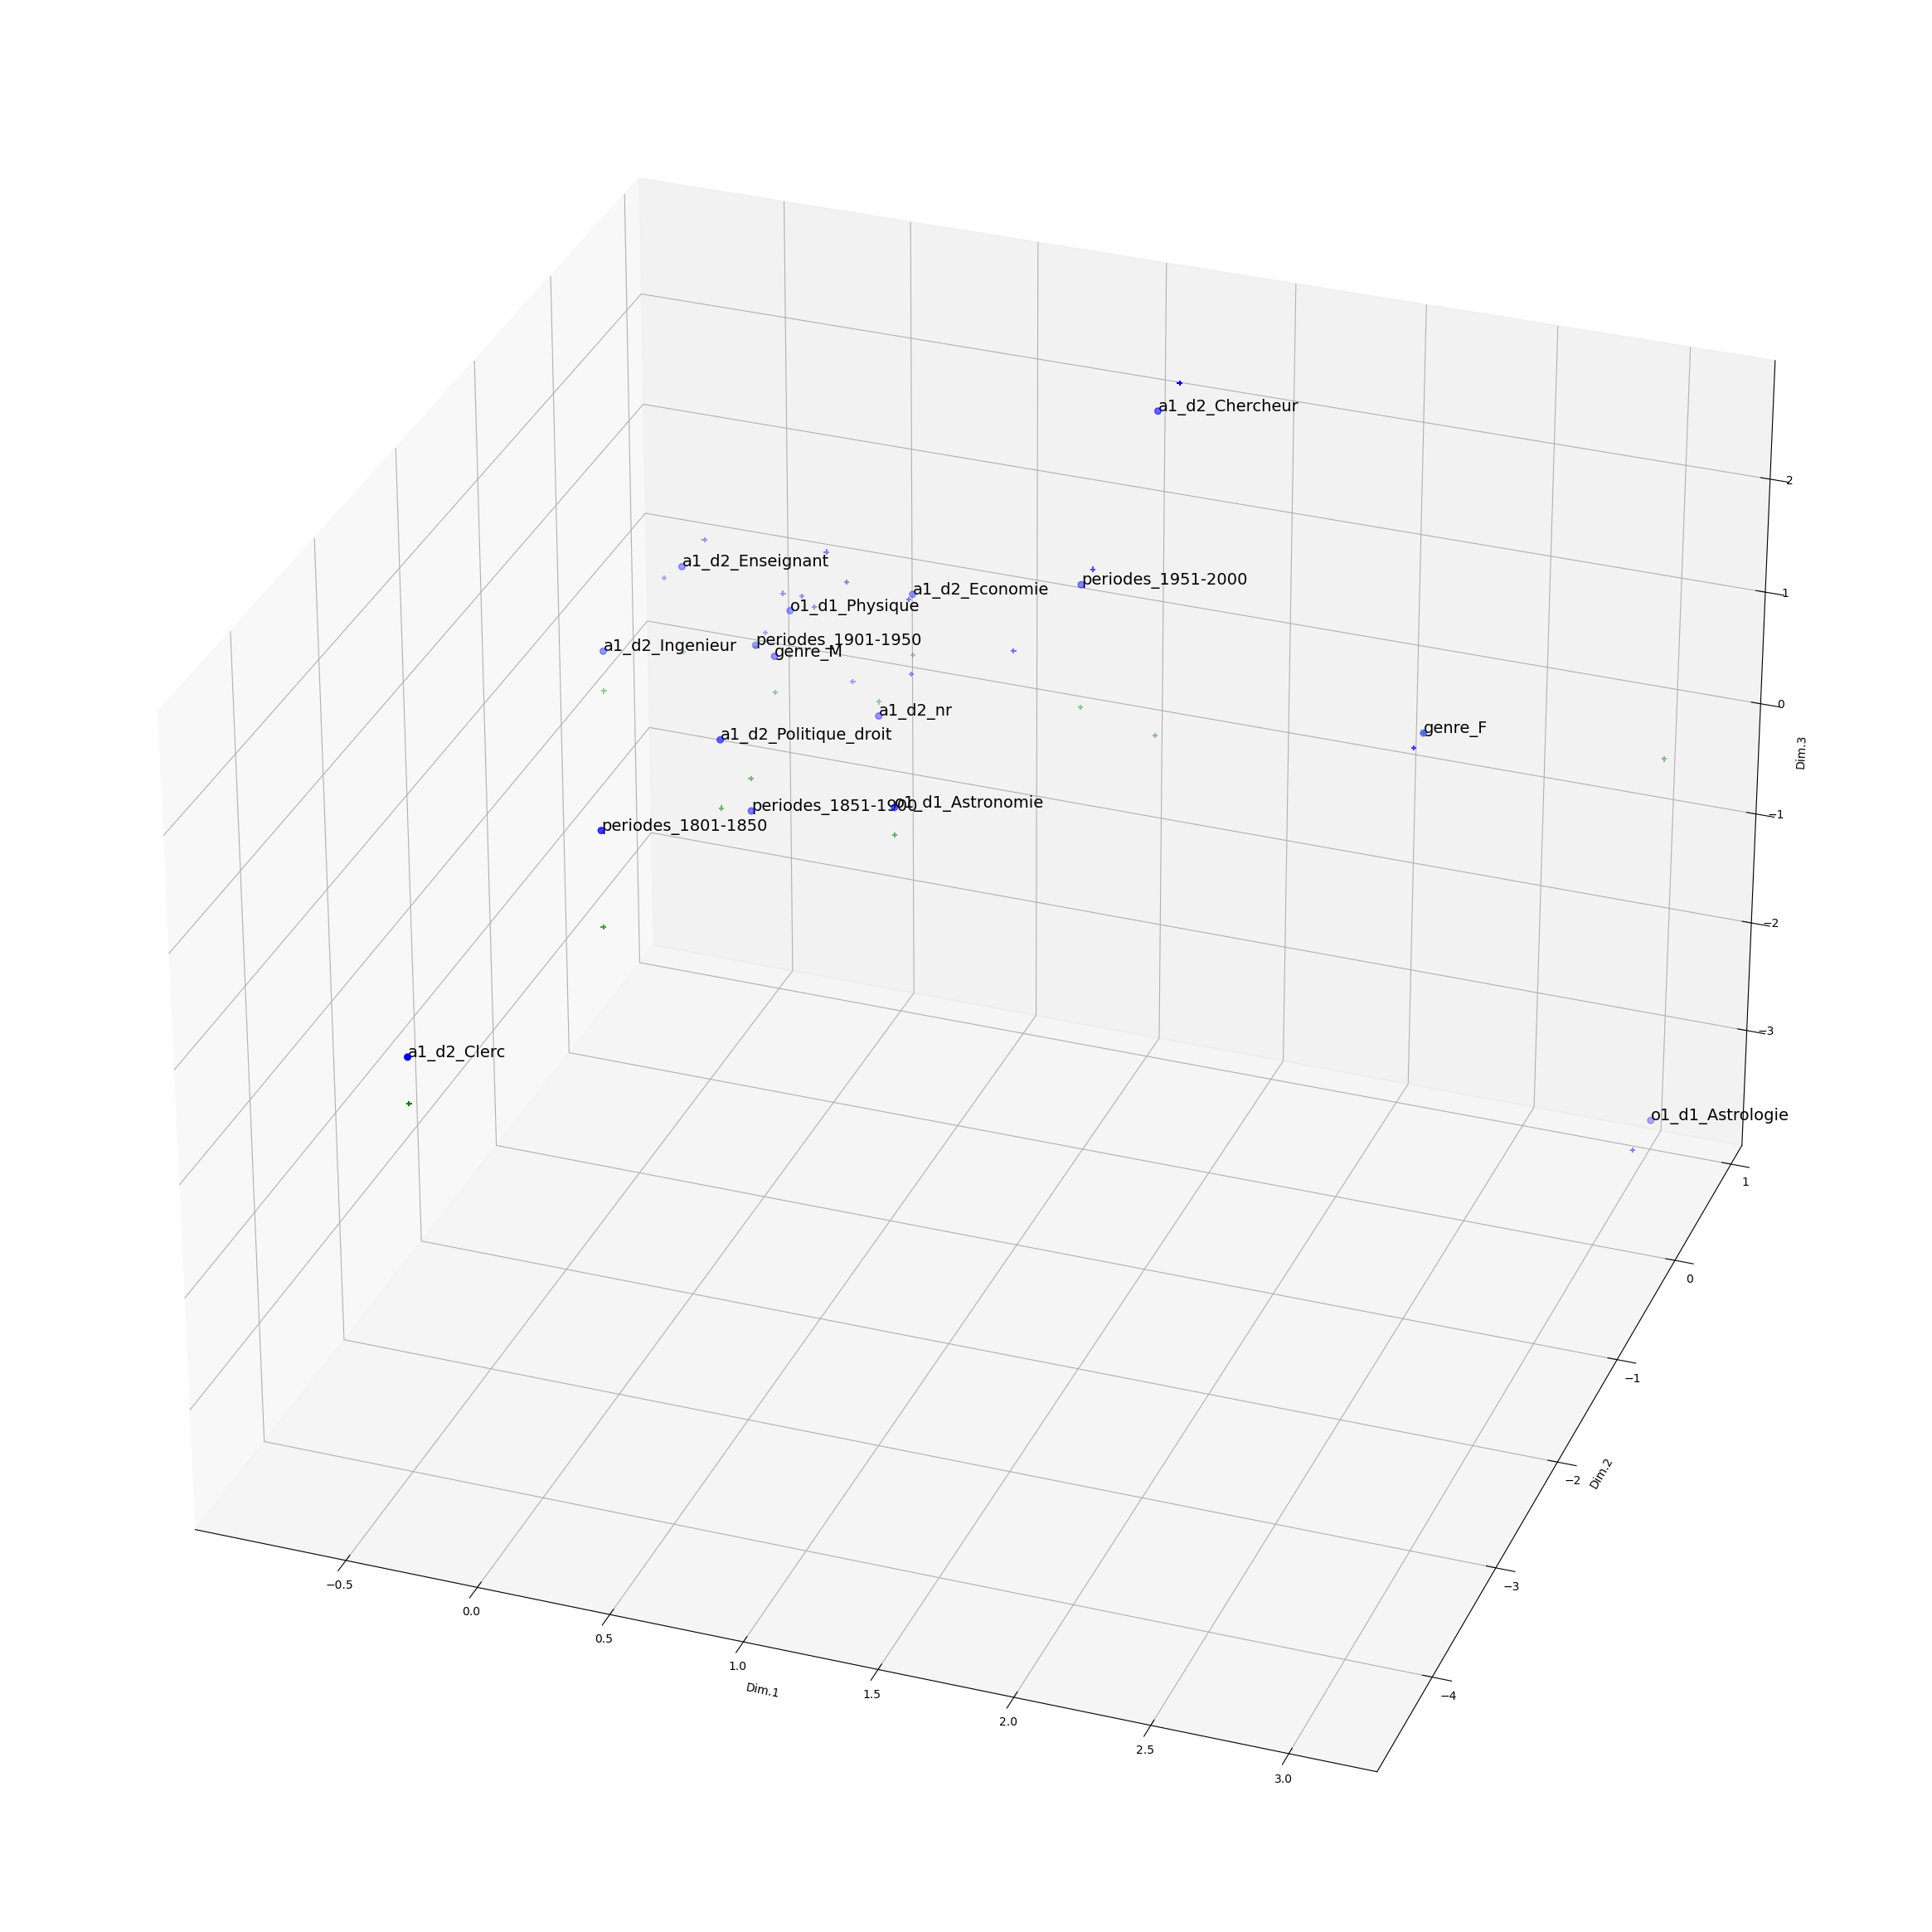

In [152]:
# plot a 3D wireframe like in the example mplot3d/wire3d_demo

fig = plt.figure(figsize=(30,30), )
ax = fig.add_subplot(111, projection='3d')

"""r1 = D3fr.iloc[:,0]
r2 = D3fr.iloc[:,1]
r3 = D3fr.iloc[:,2]"""

c1 = D3fc.iloc[:,0]
c2 = D3fc.iloc[:,1]
c3 = D3fc.iloc[:,2]


# h=[min(D3fr[2])] 
hz=[-0.3]
hy=[0.5]

### rows
"""ax.scatter(r1,r2,r3, c='red', s=30)

for x,y,z,i in zip(r1,r2,r3,D3fr.index):
    ax.text(x,y,z,i, fontsize=14)

bx = hz * len(D3fr)
ax.scatter(r1,r2,bx, marker='+', c='red', s=20)
bx = hy * len(D3fr)
ax.scatter(r1,bx,r3, marker='+', c='red', s=20)"""

### columns
ax.scatter(c1,c2,c3, c='blue', s=30)

for x,y,z,i in zip(c1,c2,c3,D3fc.index):
    ax.text(x,y,z,i, fontsize=14)

# projection sur le plan horizontal, axes 1 et 2
by = hz * len(D3fc)
ax.scatter(c1,c2,by, marker='+', c='green', s=20)
# projection sur le plan vertical, axes 2 et 3
by = hy * len(D3fc)
ax.scatter(c1,by,c3, marker='+', c='blue', s=20)

ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
ax.set_zlabel("Dim.3")

### Position:
# https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html
# Il faut travailler sur les angles pour améliorer la visualisation
ax.view_init(elev=30, azim=-70, roll=0)

#ax.zaxis.labelpad=-1.5

plt.show()

In [121]:
### Correction de Benzecri, cf. Rakotomalala, Pratique, p.313sqq

#somme en colonne
#récupérer les valeurs propres supérieur à (1/p)
lambada = acm.eig_[0][acm.eig_[0]>1/p]
print(lambada)

#appliquer la correction
lambada_prim = ((p/(p-1))*(lambada-1/p))**2
print(lambada_prim)

#faire la somme
S_prim = np.sum(lambada_prim)
print('u',S_prim)

#et produire les pourcentages
percent_prim = lambada_prim/S_prim*100

#affichage
bzc = pd.DataFrame(np.transpose(np.array([lambada_prim,percent_prim,
                                np.cumsum(percent_prim)])),columns=['Val.P','freq','Cumul_freq'],
                                index=range(1,len(percent_prim)+1))
print(bzc)

[0.31750008 0.30420929 0.27940695 0.2560484  0.2541368  0.25055825]
[8.10002022e-03 5.22426077e-03 1.53736670e-03 6.50367124e-05
 3.04233649e-05 5.54033420e-07]
u 0.014957661804038748
          Val.P       freq  Cumul_freq
1  8.100020e-03  54.152984   54.152984
2  5.224261e-03  34.926988   89.079972
3  1.537367e-03  10.278122   99.358094
4  6.503671e-05   0.434805   99.792899
5  3.042336e-05   0.203397   99.996296
6  5.540334e-07   0.003704  100.000000


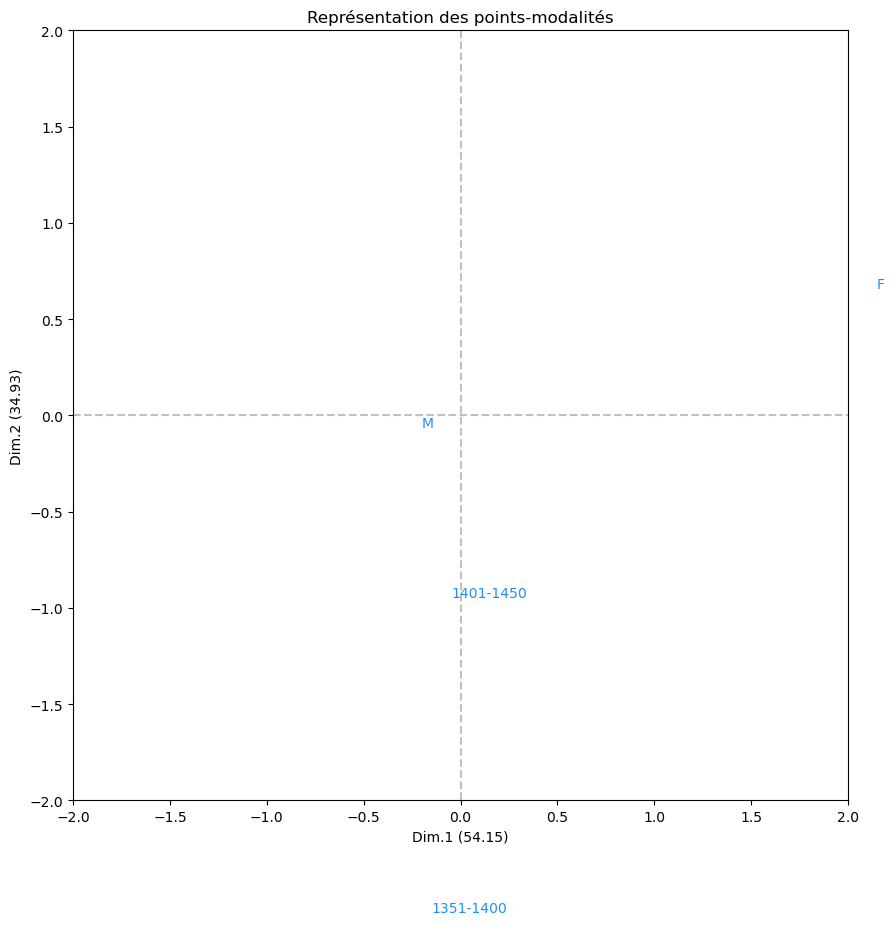

In [122]:
fix,ax = plt.subplots(figsize=(10,10))
ax.axis([-2,+2,-2,+2])
ax.plot([-2,+2],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-2,+2],color='silver',linestyle='--')
ax.set_xlabel("Dim.1 ("+ str(round(bzc.freq.iloc[0],2))+")")
ax.set_ylabel("Dim.2 ("+ str(round(bzc.freq.iloc[1],2))+")")
plt.title("Représentation des points-modalités")
for i in range(DActives.shape[1]):
    ax.text(acm.col_coord_[i,0],acm.col_coord_[i,1],X.columns[i],color='dodgerblue')
plt.show()

In [123]:
# D3fr = acm.row_topandas()[['row_coord_dim1','row_coord_dim2','row_coord_dim3']]
#print(D3fr)
D3fc = acm.col_topandas()[['col_coord_dim1','col_coord_dim2','col_coord_dim3']]
D3fc.columns

Index(['col_coord_dim1', 'col_coord_dim2', 'col_coord_dim3'], dtype='object')

In [124]:
acm.col_topandas().columns

Index(['col_coord_dim1', 'col_coord_dim2', 'col_coord_dim3', 'col_coord_dim4',
       'col_coord_dim5', 'col_coord_dim6', 'col_coord_dim7', 'col_coord_dim8',
       'col_coord_dim9', 'col_coord_dim10', 'col_coord_dim11',
       'col_coord_dim12', 'col_contrib_dim1', 'col_contrib_dim2',
       'col_contrib_dim3', 'col_contrib_dim4', 'col_contrib_dim5',
       'col_contrib_dim6', 'col_contrib_dim7', 'col_contrib_dim8',
       'col_contrib_dim9', 'col_contrib_dim10', 'col_contrib_dim11',
       'col_contrib_dim12', 'col_cos2_dim1', 'col_cos2_dim2', 'col_cos2_dim3',
       'col_cos2_dim4', 'col_cos2_dim5', 'col_cos2_dim6', 'col_cos2_dim7',
       'col_cos2_dim8', 'col_cos2_dim9', 'col_cos2_dim10', 'col_cos2_dim11',
       'col_cos2_dim12'],
      dtype='object')

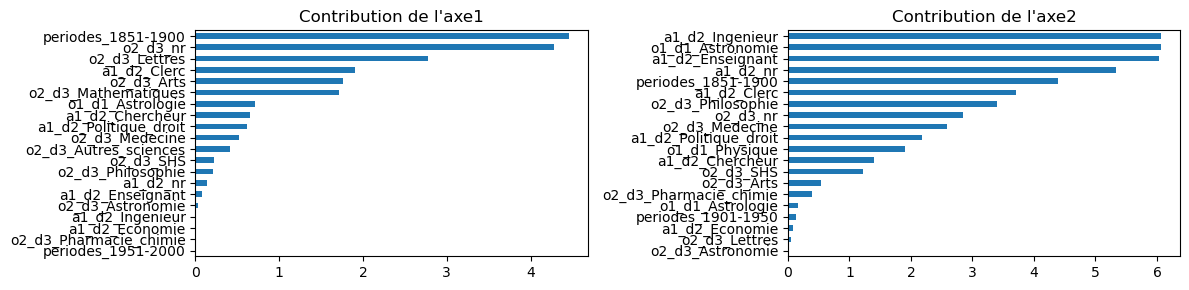

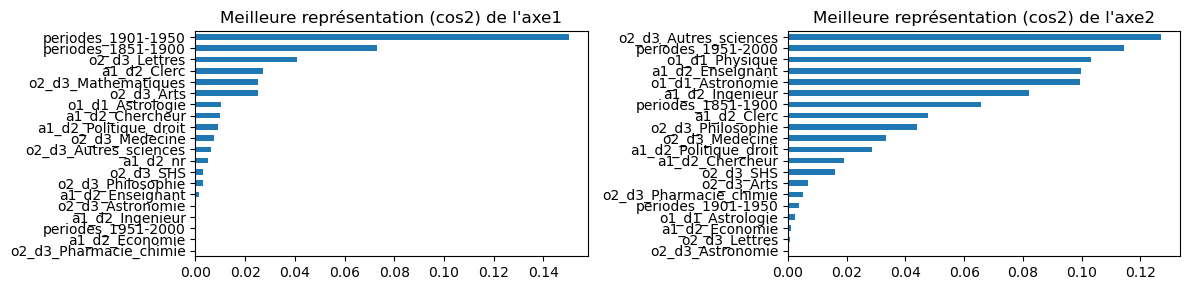

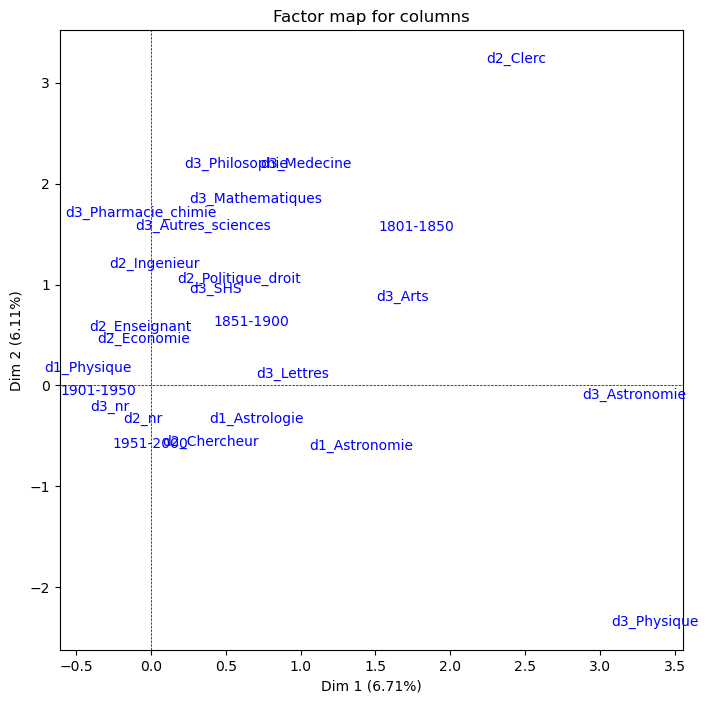

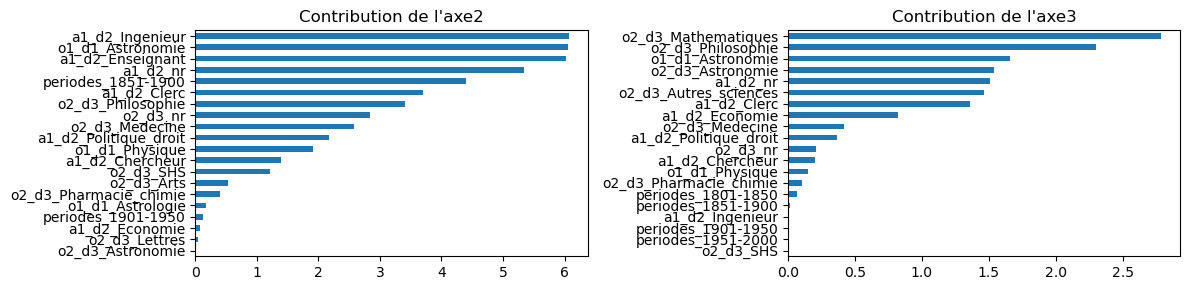

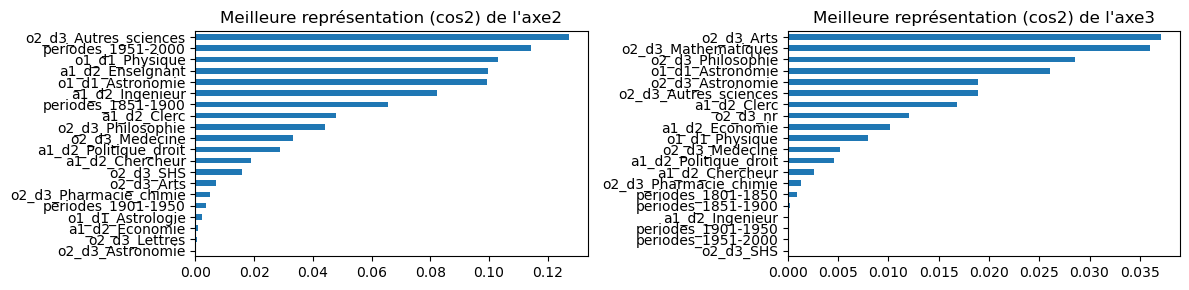

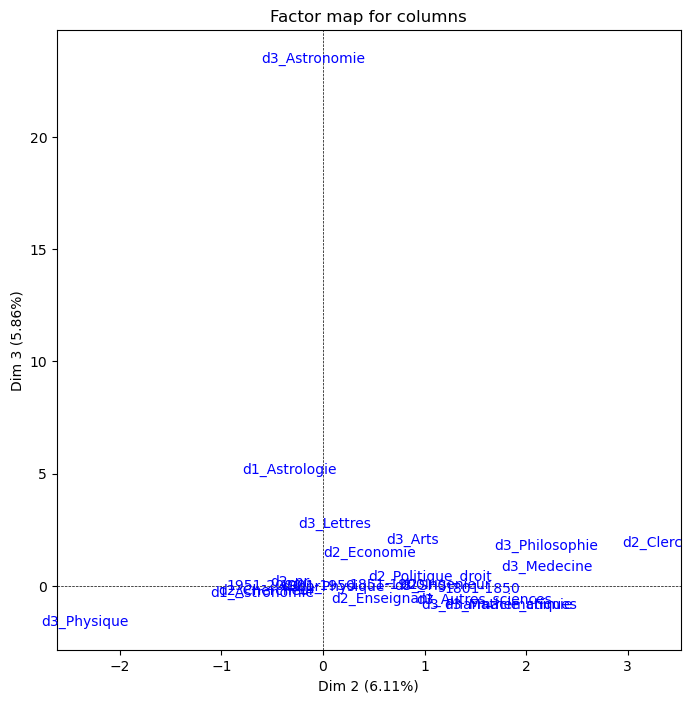

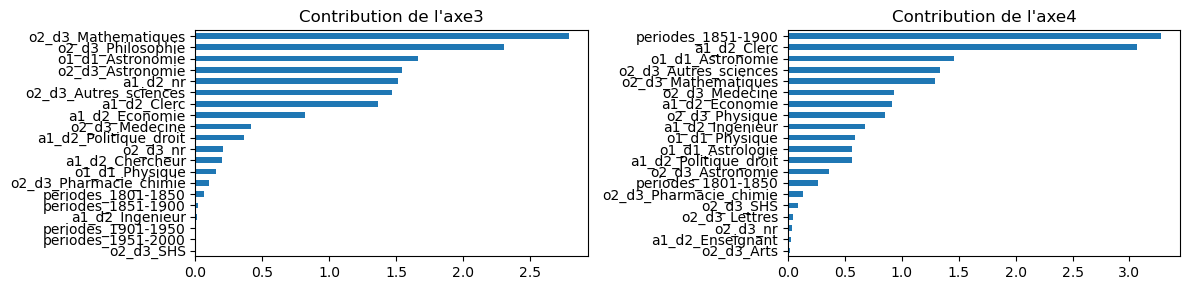

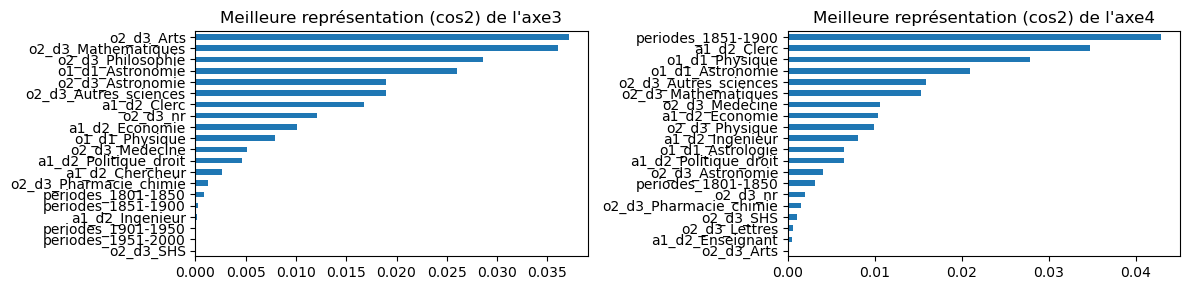

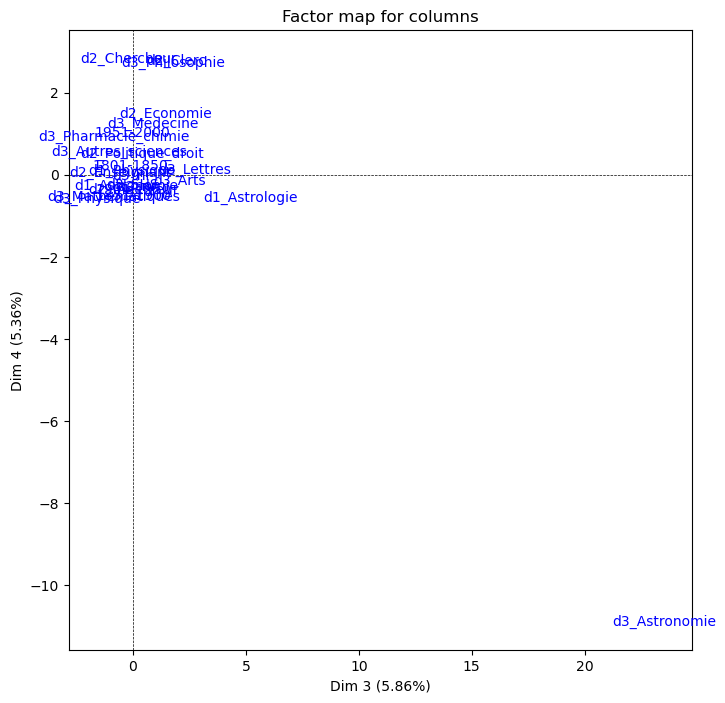

In [154]:
# Mapping des points colonnes

i = 1

### adapter le paramètre si la figure 
# est trop petite ou trop grande
param = 1.2

dfc = acm.col_topandas()

### avec la correction de Benzecri, 
# 3 axes apportent 95%  de l'information
while i < 4:    
    c1 = 'col_contrib_dim' + str(i)  
    c2 = 'col_contrib_dim' + str(1+i)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:20]
    r1.plot(kind='barh', ax=axes[0], title="Contribution de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:20]
    r2.plot(kind='barh', ax=axes[1], title="Contribution de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()



    c1 = 'col_cos2_dim' + str(i)  
    c2 = 'col_cos2_dim' + str(1+i)
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:20]
    r1.plot(kind='barh', ax=axes[0], title="Meilleure représentation (cos2) de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:20]
    r2.plot(kind='barh', ax=axes[1], title="Meilleure représentation (cos2) de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()

    w = eig.iloc[:,1][:i].values[0]*param
    h = eig.iloc[:,1][:(i+1)].values[0]*param
    
    acm.mapping_col(num_x_axis=i, num_y_axis=i+1, figsize=(w,h))
    plt.show()
    i +=1